## Product Demand Forecasting
#### Import Libraries

In [389]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import optuna

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



#### Read in dataset

In [390]:
sales_df=pd.read_csv("Historical Product Demand.csv")
print(f"There are {sales_df.shape[0]} rows and {sales_df.shape[1]} columns in this historical sales data file.")

There are 1048575 rows and 5 columns in this historical sales data file.


#### Data Preparation

In [391]:
# How the data looks
sales_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


By just look at the data, things observed:
- Product_Code should be uniq along each product.
- Warehouse should be segregated into different facilities.
- Product_Category shows differen categories of products.
- Date should be in date type.
- This project will be a regression analysis, thus the outcome Order_Demand should be numeric type.

In [392]:
#check unique values
print(f'There are {sales_df["Product_Code"].nunique()} unique Products stored in {sales_df["Warehouse"].nunique()} Warehouses. They have {sales_df["Product_Category"].nunique()} different product categories.')

There are 2160 unique Products stored in 4 Warehouses. They have 33 different product categories.


In [393]:
# General info of the dataframe
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [394]:
#missing values checking
sales_df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [395]:
11239/sales_df.shape[0]

0.010718355863910546

- Object is the only data type of our features.
- Date has 11239 missing valus which is only 1% of the data.

Before proceed with analysis, I'll ensure that the columns are converted into their appropriate data types and handle any missing values.

In [396]:
#Drop missing values since we only have 1% of the data missing.
sales_df.dropna(inplace=True)
sales_df.isna().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [397]:
#Data type converting
#sales_df['Order_Demand']=pd.to_numeric(sales_df['Order_Demand'])  I encountered this error while running: ValueError: Unable to parse string "(1)" at position 112289
sales_df['Date']=pd.to_datetime(sales_df['Date'])
sales_df['Product_Code']=sales_df['Product_Code'].astype('category')
sales_df['Warehouse']=sales_df['Warehouse'].astype('category')
sales_df['Product_Category']=sales_df['Product_Category'].astype('category')


In [398]:
print(f'This dataset contains order details of each provided product from {sales_df.Date.min()} to {sales_df.Date.max()}.')

This dataset contains order details of each provided product from 2011-01-08 00:00:00 to 2017-01-09 00:00:00.


I encountered an value error while converting 'Order_Demand' directly. It seems like there are instances with '()' around the value.

ValueError: Unable to parse string "(1)" at position 112289

In [399]:
#Handling '()'
def outcome_cleaning(x):
    if x.startswith('('):
        return int(x[1:-1])
    elif x.endswith(' '):
        return int(x[0:-1])
    else:
        return int(x)
    
sales_df['Order_Demand']= sales_df['Order_Demand'].apply(lambda x:outcome_cleaning(x))

In [400]:
#Check the dataframe again
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  category      
 1   Warehouse         1037336 non-null  category      
 2   Product_Category  1037336 non-null  category      
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  int64         
dtypes: category(3), datetime64[ns](1), int64(1)
memory usage: 27.8 MB


#### EDA and Visualization

Order Demand among Warehouses and Product Categories

In [401]:
#Order counts among warehouses
sales_df[['Warehouse']].value_counts()

Warehouse
Whse_J       764447
Whse_A       142335
Whse_S        88200
Whse_C        42354
dtype: int64

Text(0, 0.5, 'Order Counts')

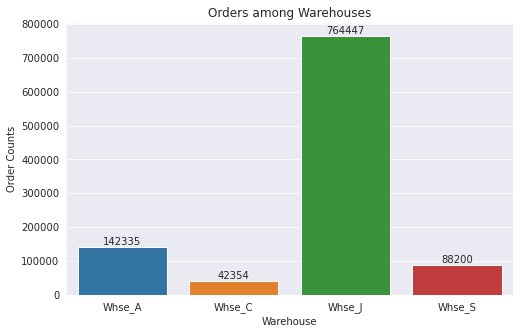

In [402]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Warehouse', data=sales_df)
ax.bar_label(ax.containers[0])
plt.title('Orders among Warehouses')
plt.ylabel('Order Counts')

- compares the number of orders by warehouses.
- Whse_J took significant more orders than other warehouses with approx. 750000 orders.
- Then Whse_A, Whse_S and Whse_C.

In [403]:
#Average order Demands by warehouses
sales_df[['Warehouse', 'Order_Demand']].groupby(['Warehouse']).mean()

,Order_Demand
Warehouse,
Whse_A,1038.939340
Whse_C,13813.840582
Whse_J,4399.520694
Whse_S,11768.987528


Text(-2.700000000000003, 0.5, 'Median Demand')

<Figure size 576x360 with 0 Axes>

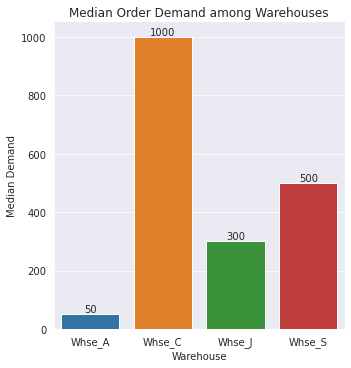

In [404]:
plt.figure(figsize=(8,5))
g =sns.catplot(x='Warehouse', y='Order_Demand', kind='bar', estimator=np.median, data=sales_df)
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
plt.title('Median Order Demand among Warehouses')
plt.ylabel('Median Demand')

Text(-9.075000000000003, 0.5, 'Average Demand')

<Figure size 576x360 with 0 Axes>

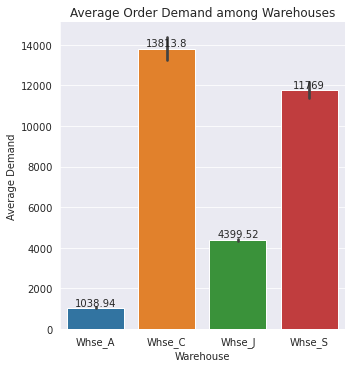

In [405]:
plt.figure(figsize=(8,5))
g =sns.catplot(x='Warehouse', y='Order_Demand', kind='bar', estimator=np.mean, data=sales_df)
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
plt.title('Average Order Demand among Warehouses')
plt.ylabel('Average Demand')

- While Whse_J may have more orders than other warehouses, Whse_C and Whse_S handle the large orders on avaerage. I assume that Whse_C and Whse_S serve a smaller number of big customers(wholesale), while Whse_J takes care of a significant larger number of small/mid customer base(Retail).
- They all suffered from outliers
- Whse_A is the loser.

To verify my assumption:

In [406]:
sales_df['Year']=sales_df['Date'].dt.year

Text(0.5, 1.0, 'Average Demand over years by Warehouse')

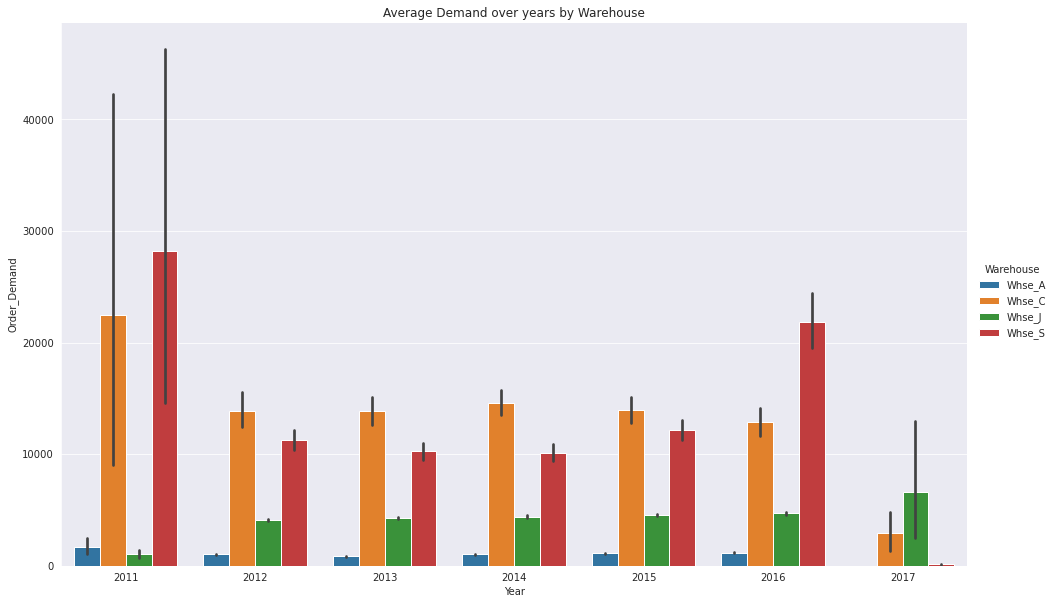

In [407]:
# Average Order Demand by warehouses from 2011 Jan to 2017 Jan
sns.catplot(data=sales_df, x="Year", y="Order_Demand", hue="Warehouse",kind="bar",height=8.27, aspect=13.7/8.27)
plt.title("Average Demand over years by Warehouse")

- A – low demand over the years
- in 2011, Whse_C and Whse S spread to large orders, after then, most of the orders in Whse_C and S exhibit a mid-sized demand
- J - primarily handled small orders
- Uniform distributed on order average


Text(0.5, 1.0, 'Order Demand vs. Warehouse by Date')

<Figure size 3600x1080 with 0 Axes>

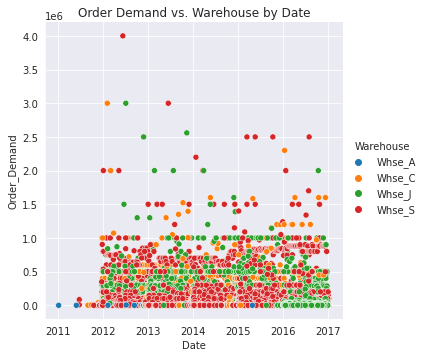

In [408]:
plt.figure(figsize=(50,15))
sns.relplot(data=sales_df, x="Date", y="Order_Demand", hue="Warehouse")
plt.title("Order Demand vs. Warehouse by Date")

- Whse_A is barely visible.
- Whse_S took a significant number of retail orders as well.
- Most of the orders in Whse_C has middle size demand which explain why its mean is high.
- Whse_J apperently primarily handled mid-size orders before 2016, then started taking most the small orders.

In [435]:
#sales_df['Product_Category'].value_counts().head(6) same result
sales_df[['Product_Category', 'Order_Demand']].groupby(['Product_Category']).sum().sort_values(by=['Order_Demand'],ascending=False).head(6)

,Order_Demand
Product_Category,
Category_019,4240159257
Category_006,405571330
Category_005,199674520
Category_007,128691531
Category_028,49055354
Category_033,42610000


Text(0.5, 1.0, 'Order Counts by Product Categories')

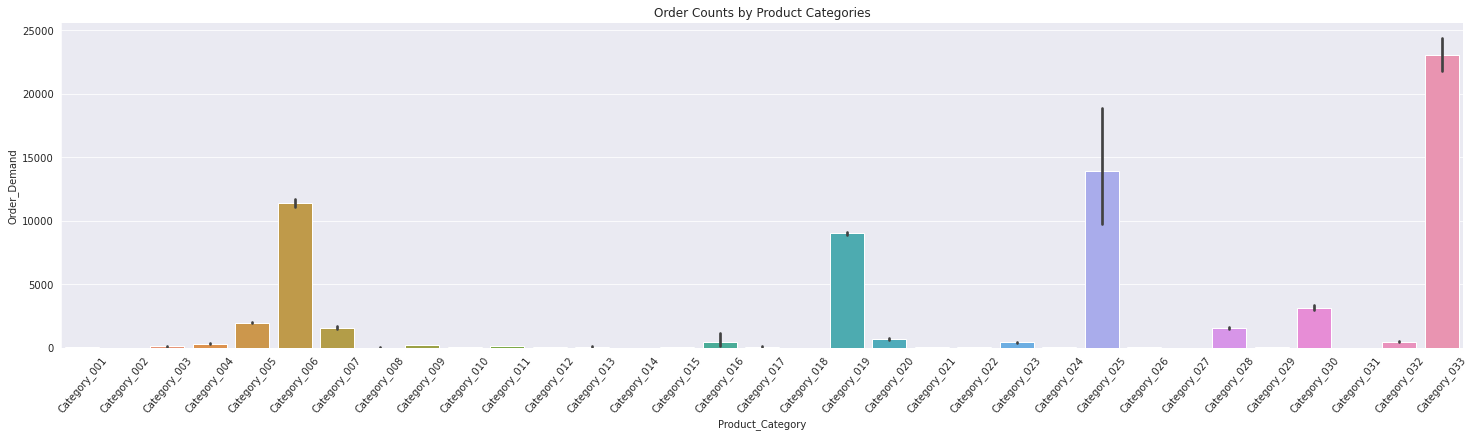

In [439]:
sns.catplot(x='Product_Category',y="Order_Demand",kind='bar',data=sales_df, height=5.27, aspect=20.7/5.27)
plt.xticks(rotation=50)
plt.title('Order Counts by Product Categories')

- Category_033 has the most orders, followed by 025, 006, 019

Text(0.5, 1.0, 'Average Order Demands of all Product Categories by warehouse')

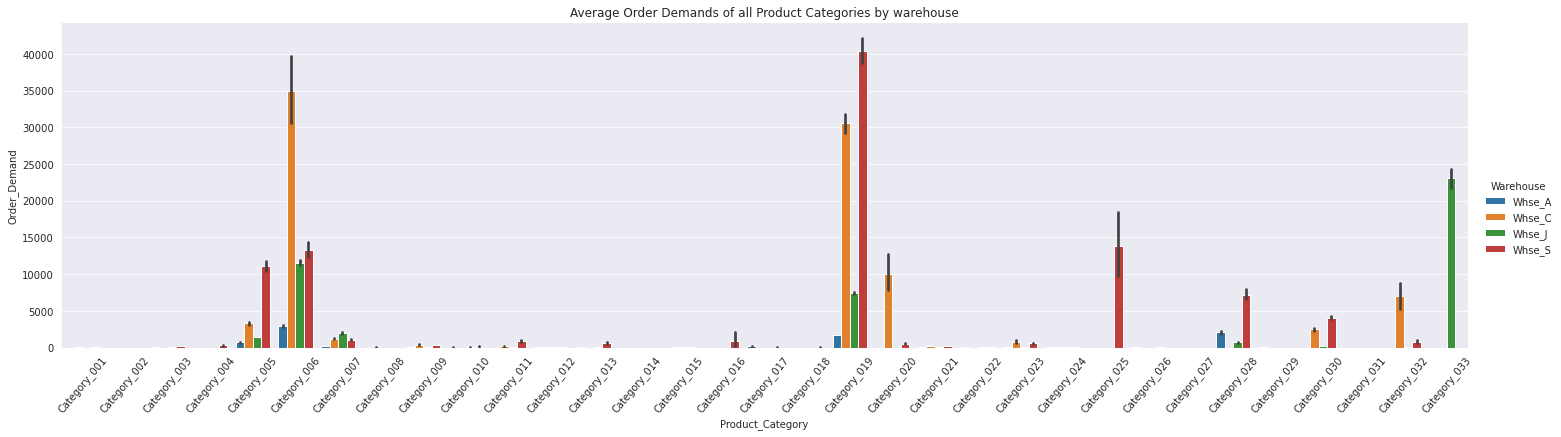

In [436]:
sns.catplot(x='Product_Category',y="Order_Demand",hue="Warehouse" ,kind='bar',data=sales_df, height=5.27, aspect=20.7/5.27)
plt.xticks(rotation=50)
plt.title('Average Order Demands of all Product Categories by warehouse')

- Category_019 is the winner overall, which sells the most in Whse_C and Whse_S
- Whse A: Category_006 > Category_028 > Category_019 > Category_005
- Whse C: Category_006 > Category_019 > Category_020 > Category_032
- Whse J: Category_033 > Category_006 > Category_019
- Whse S: Category_019 > Category_025 > Category_006 > Category_005 > Category_028 > Category_030


Order_Demand Distribution over time

In [414]:
sales_df['Year']=sales_df['Date'].dt.year
sales_df['Month']=sales_df['Date'].dt.month
sales_df['Quarter']=sales_df['Date'].dt.quarter
sales_df['Week']=sales_df['Date'].dt.week
sales_df.head(5)


/tmp/ipykernel_9448/1131137595.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sales_df['Week']=sales_df['Date'].dt.week


,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Quarter,Week
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012,7,3,30
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012,1,1,3
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012,2,1,5
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012,2,1,6
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012,3,1,9


Text(0.5, 1.0, 'Distribution of Order Demands')

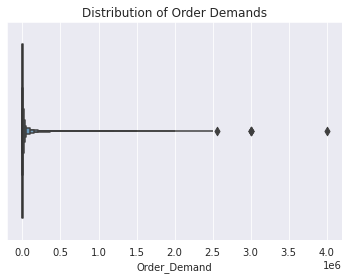

In [413]:
sns.boxenplot(x='Order_Demand', data=sales_df)
plt.title('Distribution of Order Demands')

Text(0.5, 1.0, 'Distribution of Order Demands without outlier')

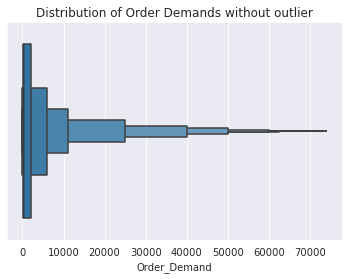

In [415]:
#Remove outliers and canceled orders
outlier_excluded=sales_df[sales_df["Order_Demand"]<sales_df["Order_Demand"].quantile(0.99)]
outlier_excluded=outlier_excluded[outlier_excluded['Order_Demand']!=0]
sns.boxenplot(x='Order_Demand', data=outlier_excluded)
plt.title('Distribution of Order Demands without outlier')

In [416]:
pd.DataFrame(outlier_excluded['Order_Demand'].describe())

,Order_Demand
count,997592.000000
mean,3103.266547
std,7881.938583
min,1.000000
25%,25.000000
50%,300.000000
75%,2000.000000
max,74000.000000


- The target variable is right skewed.
- Demand in each order is usually below 22000.
- 75% of all cases, demand is smaller than 2000.
- 50% of times, demand is less than 300.
- we have outliers when demand is 0 or 4000000.

Text(0.5, 1.0, 'Sale trends from 2011-1 to 2017-1')

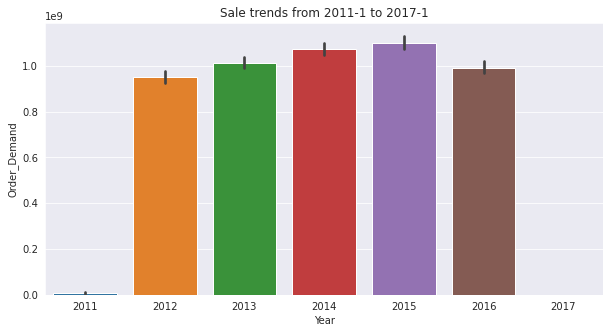

In [417]:

plt.figure(figsize=(10,5))
sns.barplot(x='Year', y='Order_Demand', estimator=np.sum,data=sales_df)
plt.title('Sale trends from 2011-1 to 2017-1')

- Demands was extremely low before 2012. Either data was missing back then or there was Not a lot business at 2011.
- Some business stratery might have been implemented at that point, demand significantly increased from 2012 onwards, but then started to decline from 2016.
- missing 2017 data

Order Demand across warehouses by month, season (find Peak season)

In [418]:
#only Jan of 2017 was provided
sales_df=sales_df.loc[sales_df['Year']!='2017']
df_2017 = outlier_excluded.loc[outlier_excluded['Year']=='2017']
outlier_excluded=outlier_excluded.loc[outlier_excluded['Year']!='2017']

In [419]:
Whse_A=sales_df.loc[:,['Product_Category','Month','Order_Demand']].loc[sales_df['Warehouse']=='Whse_A']

Text(0.5, 1.0, 'Monthly average order demand for all products in Whse_A')

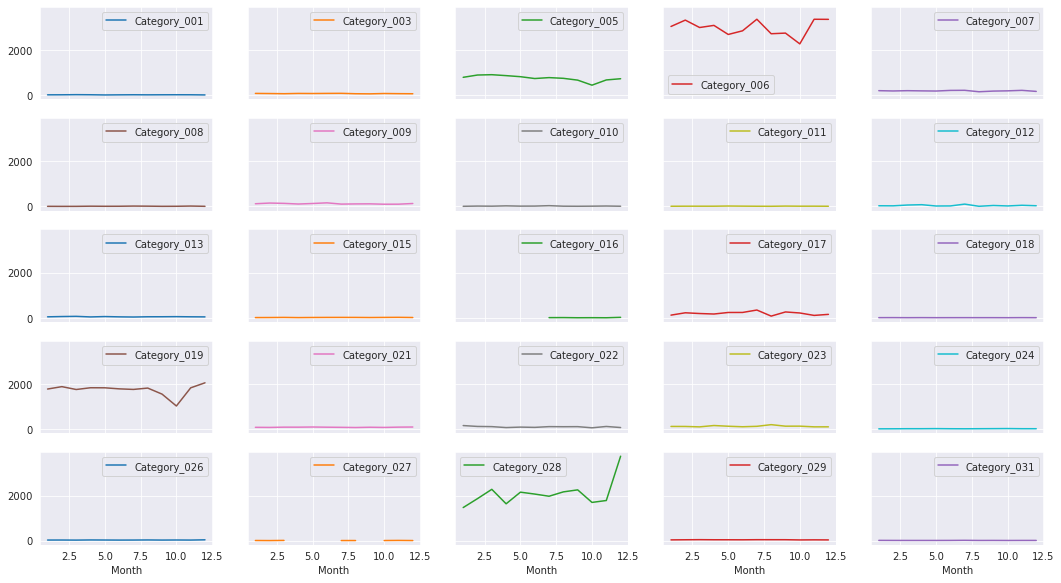

In [420]:
pd.pivot_table(Whse_A.reset_index(), 
                     index='Month',columns='Product_Category', values='Order_Demand'
                     ).plot(subplots=True,layout=(7,5),figsize=(18, 14),sharey=True)
plt.title("Monthly average order demand for all products in Whse_A")

- Replenish 006 in Oct until March, then back stock from May to July.

Text(0.5, 1.0, 'Monthly average order demand for all products in Whse_C')

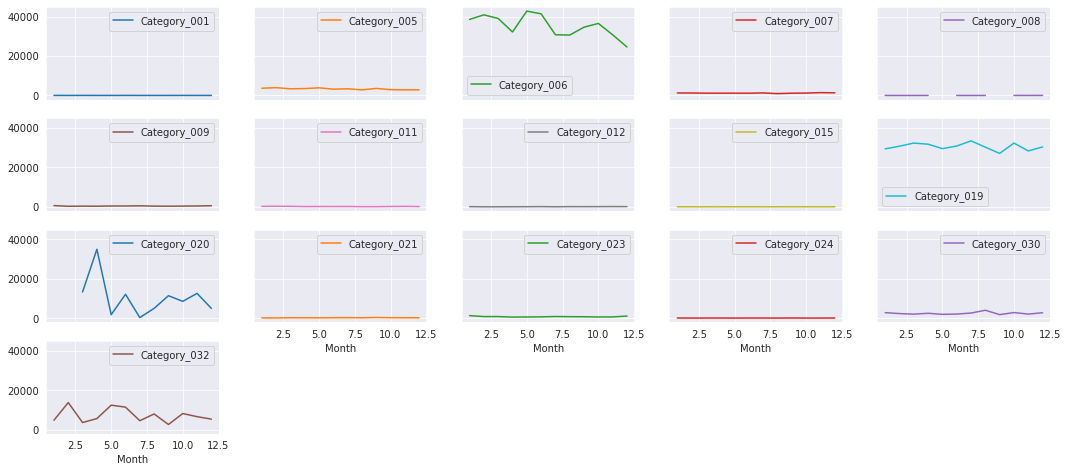

In [421]:
Whse_C=sales_df.loc[:,['Product_Category','Month','Order_Demand']].loc[sales_df['Warehouse']=='Whse_C']
pd.pivot_table(Whse_C.reset_index(), 
                     index='Month',columns='Product_Category', values='Order_Demand'
                     ).plot(subplots=True,layout=(7,5),figsize=(18, 14),sharey=True)
plt.title("Monthly average order demand for all products in Whse_C")

Text(0.5, 1.0, 'Monthly average order demand for all products in Whse_S')

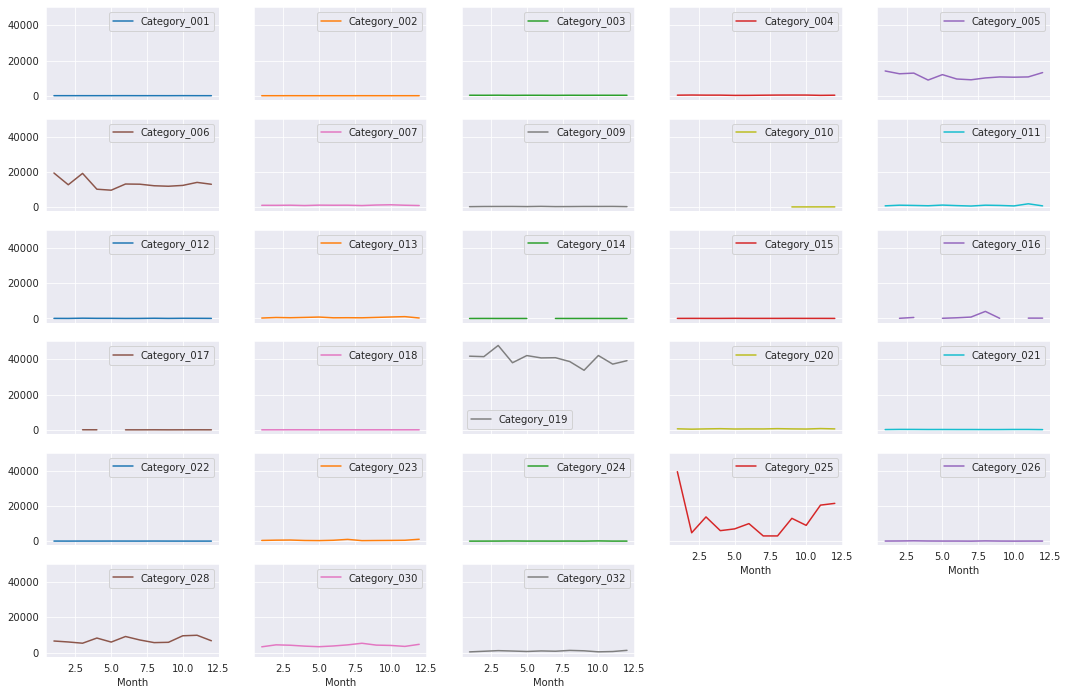

In [422]:
Whse_S=sales_df.loc[:,['Product_Category','Month','Order_Demand']].loc[sales_df['Warehouse']=='Whse_S']
pd.pivot_table(Whse_S.reset_index(), 
                     index='Month',columns='Product_Category', values='Order_Demand'
                     ).plot(subplots=True,layout=(7,5),figsize=(18, 14),sharey=True)
plt.title("Monthly average order demand for all products in Whse_S")

Text(0.5, 1.0, 'Monthly average order demand for all products in Whse_J')

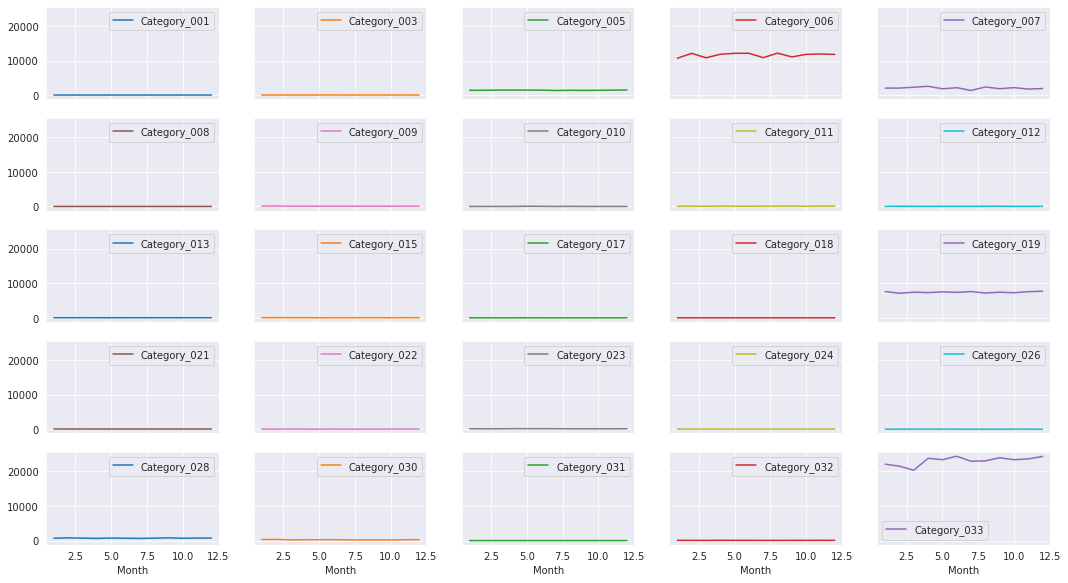

In [423]:
Whse_J=sales_df.loc[:,['Product_Category','Month','Order_Demand']].loc[sales_df['Warehouse']=='Whse_J']
pd.pivot_table(Whse_J.reset_index(), 
                     index='Month',columns='Product_Category', values='Order_Demand'
                     ).plot(subplots=True,layout=(7,5),figsize=(18, 14),sharey=True)
plt.title("Monthly average order demand for all products in Whse_J")

- allow us to identify which product categories require proactive replenishment across our warehouses. 
- Peak Month Replenishment Schedule
- procurement adjustments

### Modeling

In [424]:
#This dataset is too large to hot encoding, random resampling
outlier_excluded=outlier_excluded.set_index('Date')
final_df=outlier_excluded.sample(frac=0.10)


In [425]:
#normalize the data since the data has varying scales
scaler = MinMaxScaler()
final_df['Order_Demand']=scaler.fit_transform(final_df[['Order_Demand']])

<AxesSubplot:title={'center':'Distribution of Order_Demand'}, xlabel='Date'>

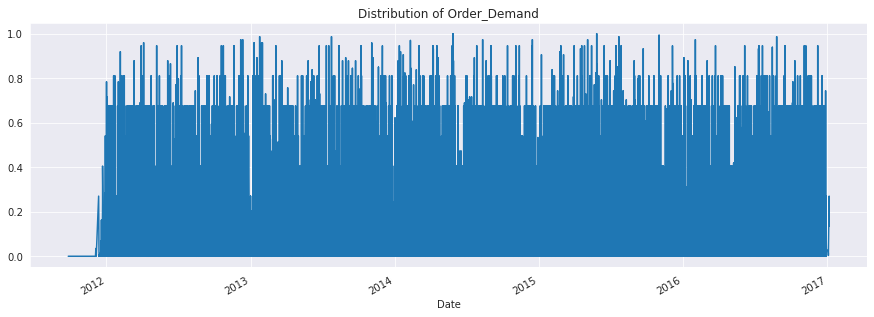

In [426]:
final_df['Order_Demand'].plot(kind='line', title='Distribution of Order_Demand',figsize=(15, 5))

In [427]:
predictors=['Warehouse','Product_Category','Month']
X=final_df[predictors]
y=final_df['Order_Demand']

In [428]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1,test_size=0.2,train_size=0.8)

In [429]:
one_hot_encoding_test_x=pd.get_dummies(test_X)
one_hot_encoding_train_x=pd.get_dummies(train_X)

In [430]:
#Ensure the test data is encoded in the same manner as the training data with the align command
X_train,X_test = one_hot_encoding_train_x.align(one_hot_encoding_test_x,join='left',axis=1)

In [431]:
#define XGB model
XGBReg = XGBRegressor()
XGBReg.fit(X_train, train_y, verbose=False)
test_X['XGBpredictions'] = XGBReg.predict(X_test)
XGB_MAE = mean_absolute_error(test_y, test_X['XGBpredictions'])
XGB_MSE = mean_squared_error(test_y, test_X['XGBpredictions'])

In [432]:
XGBReg.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)>

In [433]:
print(f"Mean Absolute Error : {XGB_MAE}")
print(f"Mean Squared Error : {XGB_MSE}")

Mean Absolute Error : 0.04575937287367729
Mean Squared Error : 0.009642764229095206


In [441]:
# Save memory
del final_df
del X
del y
del Whse_A
del Whse_C
del Whse_J
del Whse_S

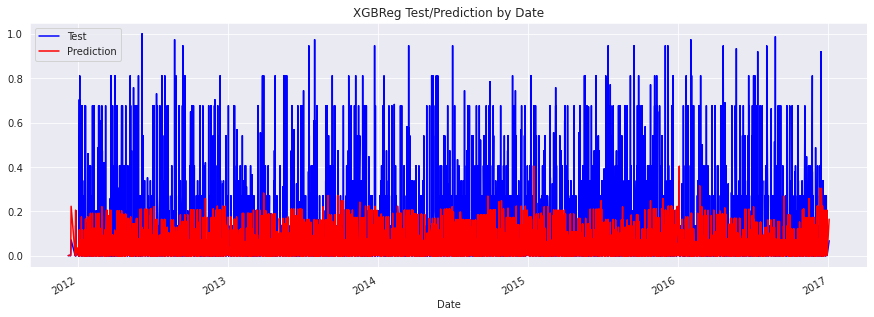

In [ ]:
test_X['Order_Demand']=test_y
train_X['Order_Demand']=train_y
fig, ax = plt.subplots( figsize = (15,5))
test_X.Order_Demand.plot(ax = ax, color = 'b', label = 'Testing', title='XGBReg Test/Prediction by Date')
test_X.XGBpredictions.plot(ax = ax, color = 'r', style = '-', label = 'Prediction')
ax.legend(['Test','Prediction'])

plt.show()

Hyper Tuning with Optuna

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBRegressor(**param)
    model.fit(X_train, train_y)
    y_pred = model.predict(X_test)
    return mean_absolute_error(test_y, y_pred)


In [ ]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=50)

[I 2023-10-18 10:17:37,958] A new study created in memory with name: regression
[I 2023-10-18 10:17:43,202] Trial 0 finished with value: 0.046013278867902324 and parameters: {'max_depth': 2, 'learning_rate': 0.8557668004287703, 'n_estimators': 728, 'min_child_weight': 4, 'gamma': 0.175435143788521, 'subsample': 0.3077803969168698, 'colsample_bytree': 0.7179488580649486, 'reg_alpha': 0.756839167133288, 'reg_lambda': 0.369268993474984, 'random_state': 257}. Best is trial 0 with value: 0.046013278867902324.
[I 2023-10-18 10:17:44,237] Trial 1 finished with value: 0.04661647476775366 and parameters: {'max_depth': 7, 'learning_rate': 0.16912935093144735, 'n_estimators': 99, 'min_child_weight': 1, 'gamma': 0.20117236996482232, 'subsample': 0.8884069965054768, 'colsample_bytree': 0.4003067893949017, 'reg_alpha': 0.8388236540763158, 'reg_lambda': 0.8447194664849804, 'random_state': 261}. Best is trial 0 with value: 0.046013278867902324.
[I 2023-10-18 10:17:52,848] Trial 2 finished with value: 

In [ ]:
tuned_xgb=XGBRegressor(**study.best_params)
tuned_xgb.fit(X_train, train_y)
test_X['tuned_XGBpredictions'] = tuned_xgb.predict(X_test)
newXGB_MAE = mean_absolute_error(test_y, test_X['tuned_XGBpredictions'])
newXGB_MSE = mean_squared_error(test_y, test_X['tuned_XGBpredictions'])

In [ ]:
print(f"Mean Absolute Error : {newXGB_MAE}")
print(f"Mean Squared Error : {newXGB_MSE}")

Mean Absolute Error : 0.045526288026556026
Mean Squared Error : 0.009638597335943272


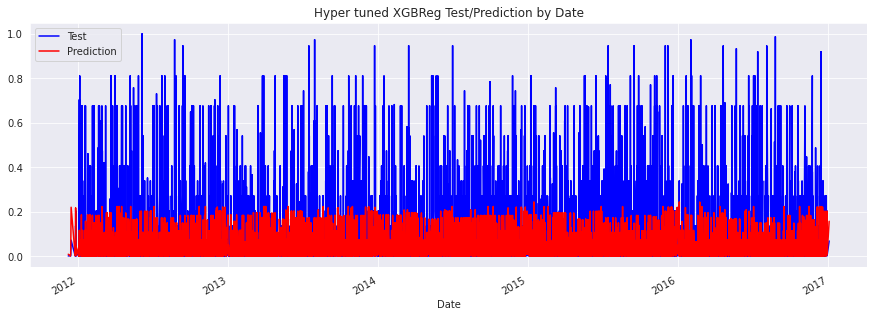

In [ ]:
fig, ax = plt.subplots( figsize = (15,5))
test_X.Order_Demand.plot(ax = ax, color = 'b', title='Hyper tuned XGBReg Test/Prediction by Date')
test_X.tuned_XGBpredictions.plot(ax = ax, color = 'r', style = '-', legend = 'tuned_Prediction')
ax.legend(['Test','Prediction'])
plt.show()

- errors were extremely low on the training set, the model didn’t fit well on the test set
- Overfitting in both XGB models

Time Series forecasting

- We want to predict the order demands volume in a monthly manner

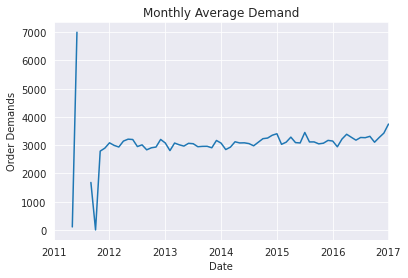

In [ ]:
final_month=outlier_excluded.resample('MS').mean()
final_month.Order_Demand.plot(title='Monthly Average Demand')
plt.ylabel('Order Demands')
plt.xlabel('Date')
plt.show()

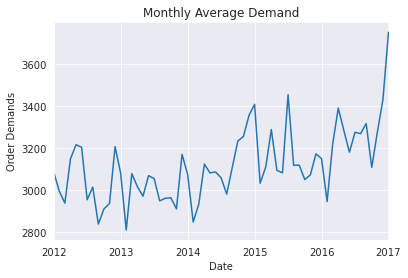

In [ ]:
#remove the chaos before 2012
final_month=final_month.loc[final_month.index >= '2012-01-01']
final_month.Order_Demand.plot(title='Monthly Average Demand')
plt.ylabel('Order Demands')
plt.xlabel('Date')
plt.show()

- The demand volume consistently displays an upward trend over the years.
- it also shows repeated peaks both before the middle of the year and at the year's end.

In [ ]:
#check stationarity using Dickey-fuller test
adfuller(final_month['Order_Demand'],autolag='AIC')

(-1.3114517130110128,
 0.6239169917319174,
 2,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 628.5513610870509)

a p-value of 0.623 is greater then 0.05, which indicates the non-stationary.

In [ ]:
#making the time series Stationary, take the difference
diff=final_month['Order_Demand'].diff()
diff.head(5)

Date
2012-01-01           NaN
2012-02-01    -91.275980
2012-03-01    -57.006915
2012-04-01    210.350484
2012-05-01     67.312263
Freq: MS, Name: Order_Demand, dtype: float64

In [ ]:
diff.dropna(inplace=True)
diff.head(5)

Date
2012-02-01    -91.275980
2012-03-01    -57.006915
2012-04-01    210.350484
2012-05-01     67.312263
2012-06-01    -12.049665
Freq: MS, Name: Order_Demand, dtype: float64

(-8.603391729214342,
 6.773425829873313e-14,
 1,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 615.2766280550708)

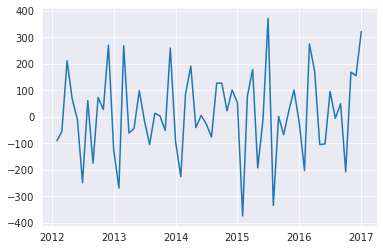

In [ ]:
plt.plot(diff)
adfuller(diff,autolag='AIC')

- a p value of 6.77e-14 indicating a stationary time series

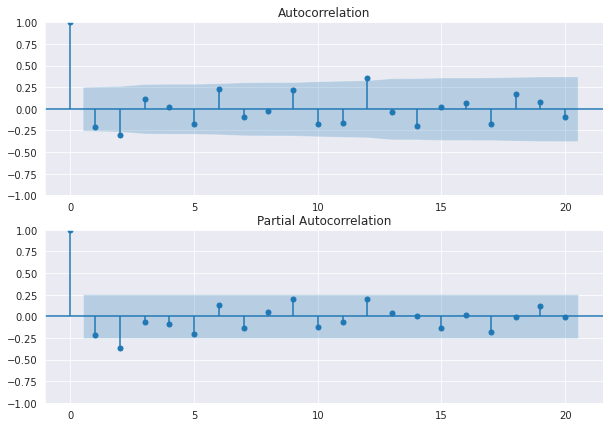

In [ ]:
#find p,q,d by ploting acf and pacf
fig = plt.figure(figsize = (10,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff, lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff, lags = 20, method='ywm', ax = ax2)
plt.show()

lag 2 are strong in both charts, so my p and q are 2. and I differentiate only once so d is 1, thus
p:2
q:2
d:1

In [442]:
#spliting training and testing model
train = diff[:'2016-01-01']
test = diff['2016-01-01':'2017-01-01']

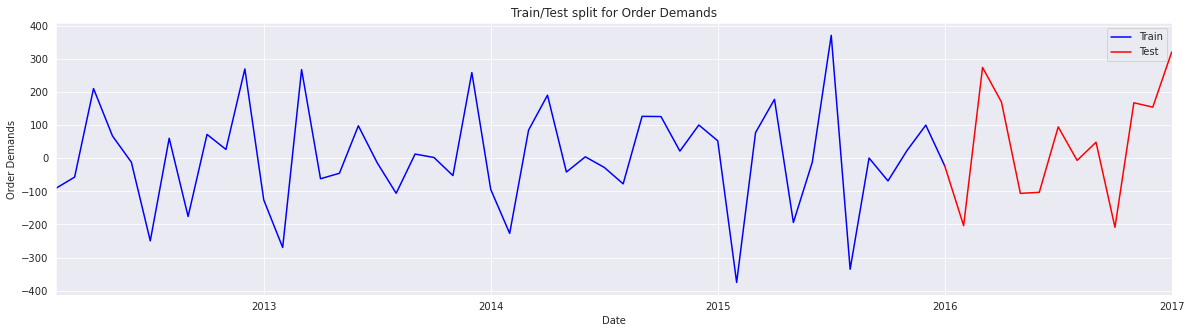

In [ ]:
fig, ax = plt.subplots( figsize = (20,5))
train.plot(ax = ax, color = 'b')
test.plot(ax = ax, color = 'r')
ax.legend(labels=['Train','Test'])
plt.ylabel('Order Demands')
plt.xlabel('Date')
plt.title("Train/Test split for Order Demands")
plt.show()

In [ ]:
tsModel = ARIMA(train,order=(2,2,1)).fit()
print(tsModel.summary())


                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                   48
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -306.391
Date:                Wed, 18 Oct 2023   AIC                            620.782
Time:                        15:03:55   BIC                            628.097
Sample:                    02-01-2012   HQIC                           623.523
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7538      0.129     -5.855      0.000      -1.006      -0.501
ar.L2         -0.5788      0.116     -5.011      0.000      -0.805      -0.352
ma.L1         -0.9999      0.224     -4.461      0.0

Based on the summary:
- The dependent variable is Order_Demand, which we'are trying to predict.
- Data range from Feb 2012 to Jan 2016. Jan 2012 were removed when adjust stationary
- The negative coef indicate our lag variables are negatively correlated with the time series.
- the p value for Ljung-box is above 0.05, we can't reject the null that the errors are white noise.
- the p value for heteroscedasticity is above 0.05, indicating our error residuals have the same variance.

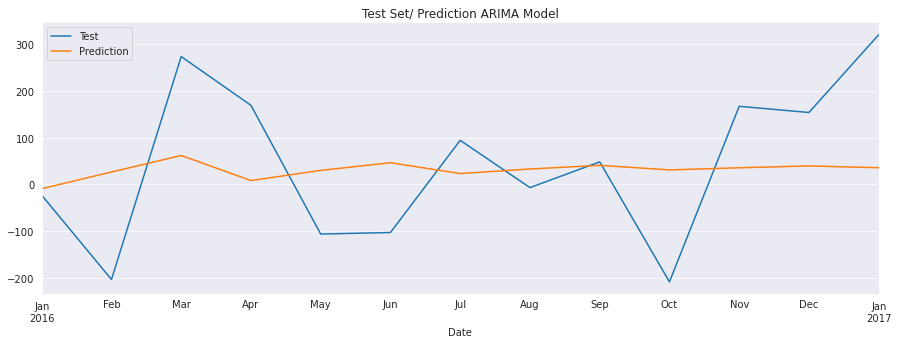

In [ ]:
ARIMApred = tsModel.predict(start = test.index[0], end = test.index[-1])

#plot test and pred
fig, ax = plt.subplots(figsize=(15, 5))
test.plot(ax=ax, title='Test Set/ Prediction ARIMA Model')
ARIMApred.plot(ax=ax)
ax.legend(['Test', 'Prediction'])
plt.show()

In [ ]:
ARIMA_MAE = mean_absolute_error(test, ARIMApred)
ARIMA_MSE = mean_squared_error(test, ARIMApred)
print(f'ARIMA MAE: {ARIMA_MAE}')
print(f'ARIMA MSE: {ARIMA_MSE}')

ARIMA MAE: 137.86376338003342
ARIMA MSE: 26214.21174036921


In [ ]:
#try with sarimax model

sarima_model=SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit()

/home/xuan1113/miniconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80527D+00    |proj g|=  7.45051D-02

At iterate    5    f=  2.79004D+00    |proj g|=  2.69414D-02

At iterate   10    f=  2.78846D+00    |proj g|=  7.04851D-04

At iterate   15    f=  2.78809D+00    |proj g|=  7.95937D-03

At iterate   20    f=  2.78097D+00    |proj g|=  1.16085D-02

At iterate   25    f=  2.77937D+00    |proj g|=  5.50549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   

In [ ]:
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.410
Date:                            Wed, 18 Oct 2023   AIC                            276.819
Time:                                    15:04:29   BIC                            282.042
Sample:                                02-01-2012   HQIC                           277.953
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3053      0.290     -1.052      0.293      -0.874       0.263
ma.L1         -0.9258      0.382   

- the p values of ar.SL12 and ma.S.L12 are significant as their p values are below 0.05
- we can't rejuct assumptions about white noise.
- Our residuals show same variance.

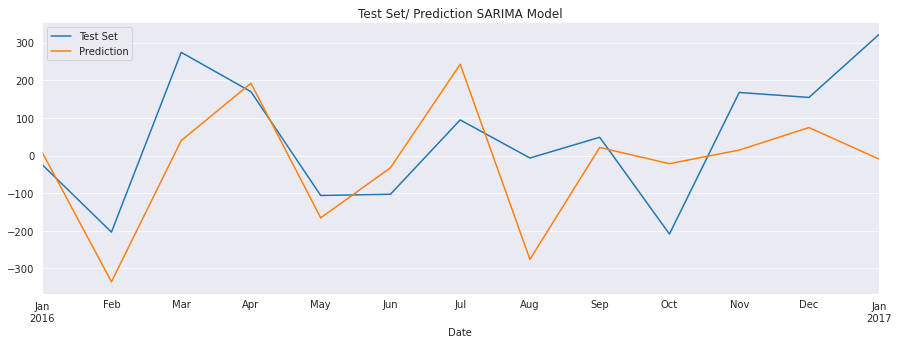

In [ ]:
SARIMApred = sarima_model.predict(start = test.index[0], end = test.index[-1])

#plot test and pred
fig, ax = plt.subplots(figsize=(15, 5))
test.plot(ax=ax, label='Testing Set', title='Test Set/ Prediction SARIMA Model')
SARIMApred.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Prediction'])
plt.show()

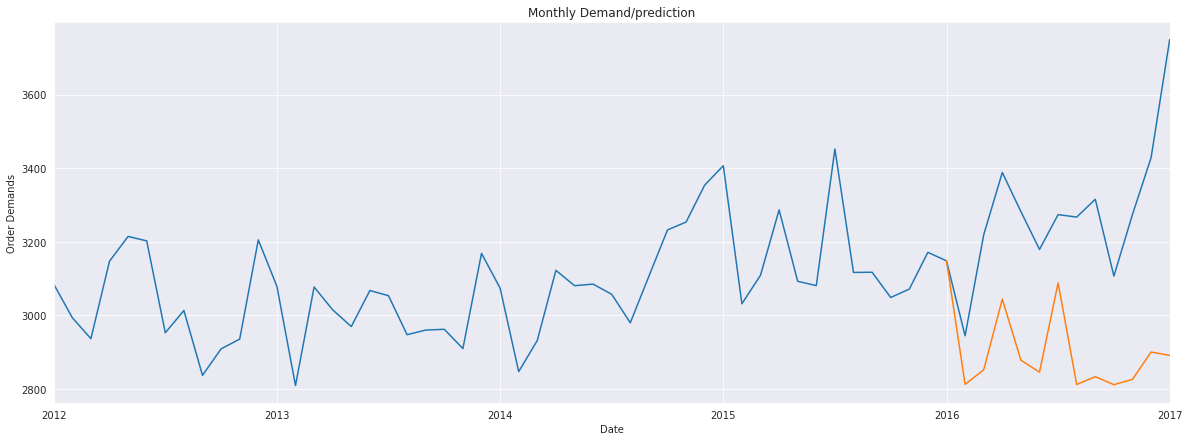

In [ ]:
SARIMApred.iloc[0]=final_month.query('index == "2016-01-01"')['Order_Demand']
pred_sarima = SARIMApred.cumsum()

fig, ax = plt.subplots(figsize = (20,7))
final_month.Order_Demand.plot(ax=ax, label='Order Demand', title='Monthly Demand/prediction')
pred_sarima.plot(ax=ax, label='Prediction')
plt.ylabel('Order Demands')
plt.show()

In [ ]:
SARIMA_MAE = mean_absolute_error(test, SARIMApred)
SARIMA_MSE = mean_squared_error(test, SARIMApred)
print(f'SARIMA MAE: {SARIMA_MAE}')
print(f'SARIMA MSE: {SARIMA_MSE}')

SARIMA MAE: 131.70815835618197
SARIMA MSE: 26914.02981170633


- The prediction line did not align well when I converted it back to the original scale. 